# Importing & Reading

**This notebook presents an implementation of the research paper "SCovNet: A skip connection-based feature union deep learning technique with statistical approach analysis for the detection of COVID-19".**

**You can view the original paper** **[HERE](https://www.mdpi.com/1424-8220/22/24/9983)** 

**In addition to replicating the model, we also explore four popular explainability techniques — LIME, Grad-CAM, and DeepLIFT — to interpret the model’s behavior and understand its decision-making process.**



In [3]:
# Core Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
import cv2
from skimage.io import imread
from skimage.transform import resize
from skimage.segmentation import mark_boundaries, quickshift

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, AveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Model Evaluation
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)

# LIME for Model Interpretability
from lime import lime_image

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Concatenate, Flatten, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

2025-05-02 15:15:12.724487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746198912.979846      51 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746198913.047122      51 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
base_path = "/kaggle/input/feature-selelcted-dataset"
categories = ['normal', 'covid19', 'pneumonia']
image_size = (224, 224)

In [5]:
def load_images_from_folder(folder_path, category, images_list, labels_list):
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = load_img(img_path, color_mode="grayscale", target_size=(224, 224))
        img_array = img_to_array(img) / 255.0 
        images_list.append(img_array)
        labels_list.append(category)

In [6]:
# Load training data
train_path = os.path.join(base_path, 'train')
train_images, train_labels = [], []

for category in categories:
    category_path = os.path.join(train_path, category)
    print(f"Loading training data from {category_path}...")
    load_images_from_folder(category_path, category, train_images, train_labels)

Loading training data from /kaggle/input/feature-selelcted-dataset/train/normal...
Loading training data from /kaggle/input/feature-selelcted-dataset/train/covid19...
Loading training data from /kaggle/input/feature-selelcted-dataset/train/pneumonia...


In [7]:
# Load test data
test_path = os.path.join(base_path, 'test')
test_images, test_labels = [], []

for category in categories:
    category_path = os.path.join(test_path, category)
    print(f"Loading test data from {category_path}...")
    load_images_from_folder(category_path, category, test_images, test_labels)

Loading test data from /kaggle/input/feature-selelcted-dataset/test/normal...
Loading test data from /kaggle/input/feature-selelcted-dataset/test/covid19...
Loading test data from /kaggle/input/feature-selelcted-dataset/test/pneumonia...


In [8]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [9]:
label_mapping = {'covid19': 0, 'pneumonia': 1,'normal': 2}

train_labels_int = np.array([label_mapping[label] for label in train_labels], dtype='int32')
test_labels_int = np.array([label_mapping[label] for label in test_labels], dtype='int32')

train_labels = tf.keras.utils.to_categorical(train_labels_int, num_classes=3).astype('float32')
test_labels = tf.keras.utils.to_categorical(test_labels_int, num_classes=3).astype('float32')

In [10]:
test_images.shape

(302, 224, 224, 1)

# Model Initialization

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Concatenate, Flatten, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the Dense Block (matches Figure b)
def dense_block(x, filters, num_layers):
    for _ in range(num_layers):
        y = Conv2D(filters, 3, padding='same')(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        x = Concatenate()([x, y])  # Dense connection (concatenation)
    return x

# Define the Squeeze Block (matches Figure c)
def squeeze_block(x, filters_in, filters_mid, filters_out):
    y = Conv2D(filters_in, 1, padding='same')(x)  # 1x1 conv
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(filters_mid, 1, padding='same')(y)  # 1x1 conv
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(filters_out, 3, padding='same')(y)  # 3x3 conv
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    if x.shape[-1] != filters_out:
        x = Conv2D(filters_out, 1, padding='same')(x)  # Adjust input channels
    return Add()([x, y])  # Residual connection

# Build the DCSCNN model (adjusted for 224x224 input)
def build_dcscnn(input_shape=(224, 224, 1), num_classes=3):
    inputs = Input(shape=input_shape)

    # Initial Convolution
    x = Conv2D(64, 5, strides=2, padding='same')(inputs)  # 224x224 → 112x112, 64 filters
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Dense Block 1 and Squeeze Block 1
    x = dense_block(x, 128, 2)  # 112x112, 2x3x3 conv, filters 128, 128 → 64 + 128 + 128 = 320 channels
    x = squeeze_block(x, 64, 128, 128)  # 112x112, [1x1, 1x1, 3x3], filters 64, 128, 128 → 128 channels
    x = MaxPooling2D(2, strides=2)(x)  # 112x112 → 56x56

    # Dense Block 2 and Squeeze Block 2
    x = dense_block(x, 256, 2)  # 56x56, 2x3x3 conv, filters 256, 512 → 128 + 256 + 512 = 896 channels
    x = squeeze_block(x, 128, 256, 256)  # 56x56, [1x1, 1x1, 3x3], filters 128, 256, 256 → 256 channels
    x = MaxPooling2D(2, strides=2)(x)  # 56x56 → 28x28

    # Dense Block 3 and Squeeze Block 3
    x = dense_block(x, 512, 2)  # 28x28, 2x3x3 conv, filters 512, 256 → 256 + 512 + 256 = 1024 channels
    x = squeeze_block(x, 256, 512, 512)  # 28x28, [1x1, 1x1, 3x3], filters 256, 512, 512 → 512 channels
    x = MaxPooling2D(2, strides=2)(x)  # 28x28 → 14x14

    # Dense Block 4 and Squeeze Block 4
    x = dense_block(x, 128, 2)  # 14x14, 2x3x3 conv, filters 128, 128 → 512 + 128 + 128 = 768 channels
    x = squeeze_block(x, 64, 128, 128)  # 14x14, [1x1, 1x1, 3x3], filters 64, 128, 128 → 128 channels

    # Final Convolution
    x = Conv2D(64, 1, padding='same')(x)  # 14x14, 64 filters
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Classification Block
    x = Flatten()(x)  # 14x14x64 = 12544
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Create and compile the model
model = build_dcscnn(input_shape=(224, 224, 1), num_classes=3)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

I0000 00:00:1746198940.789808      51 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746198940.790518      51 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          1,664 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 112, 112, 128)  │         73,856 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 112, 112, 128)  │            512 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 112, 112, 128)  │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 112, 112, 192)  │              0 │ activation[0][0],      │
│                           │                        │                │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 128)  │        221,312 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 112, 112, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 112, 112, 320)  │              0 │ concatenate[0][0],     │
│ (Concatenate)             │                        │                │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 64)   │         20,544 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 112, 112, 64)   │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 112, 112, 64)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 112, 112, 128)  │          8,320 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 12,818,723 (48.90 MB)

 Trainable params: 12,809,251 (48.86 MB)

 Non-trainable params: 9,472 (37.00 KB)

In [12]:
# Training (no resizing needed since input matches your data)
history = model.fit(
    train_images, train_labels,
    validation_data=(test_images, test_labels),
    batch_size=8,
    epochs=100,
    callbacks=[tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')]
)

Epoch 1/100


I0000 00:00:1746198964.355846     110 service.cc:148] XLA service 0x7b65f4003ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746198964.356843     110 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746198964.356870     110 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746198966.353647     110 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746198998.144219     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


151/151 ━━━━━━━━━━━━━━━━━━━━ 125s 466ms/step - accuracy: 0.5772 - loss: 1.0807 - val_accuracy: 0.3344 - val_loss: 2.7184
Epoch 2/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 34s 227ms/step - accuracy: 0.7824 - loss: 0.4996 - val_accuracy: 0.3344 - val_loss: 3.0773
Epoch 3/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 242ms/step - accuracy: 0.8295 - loss: 0.3872 - val_accuracy: 0.5530 - val_loss: 1.1793
Epoch 4/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - accuracy: 0.8621 - loss: 0.3300 - val_accuracy: 0.7881 - val_loss: 0.5867
Epoch 5/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - accuracy: 0.8962 - loss: 0.2695 - val_accuracy: 0.8146 - val_loss: 0.5600
Epoch 6/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 236ms/step - accuracy: 0.9136 - loss: 0.2157 - val_accuracy: 0.7285 - val_loss: 1.3544
Epoch 7/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 35s 235ms/step - accuracy: 0.9113 - loss: 0.2307 - val_accuracy: 0.7947 - val_loss: 0.5692
Epoch 8/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 236ms/step - accuracy: 0.9526 - loss: 0.14

# Model Testing

In [13]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print('Test acc: ',test_accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8997 - loss: 0.6260 
Test acc:  0.8774834275245667


In [14]:
y_pred_probs = model.predict(test_images)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(test_labels, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 441ms/step


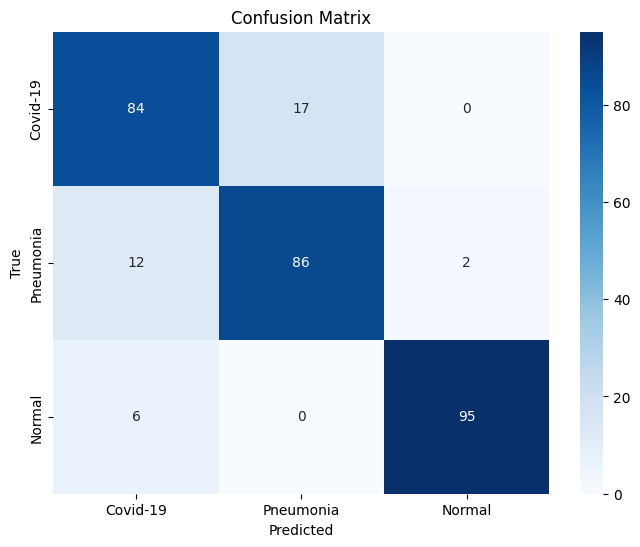

In [15]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Covid-19', 'Pneumonia', 'Normal'], 
            yticklabels=['Covid-19', 'Pneumonia', 'Normal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

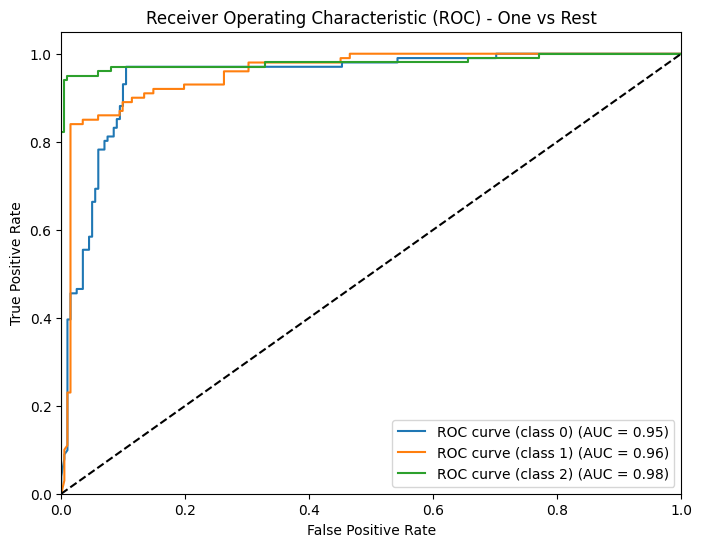

In [16]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - One vs Rest')
plt.legend(loc='lower right')
plt.show()

In [17]:
# Print AUC scores
print("AUC Scores per class:")
for i in range(3):
    print(f"Class {i}: {roc_auc[i]:.2f}")

AUC Scores per class:
Class 0: 0.95
Class 1: 0.96
Class 2: 0.98


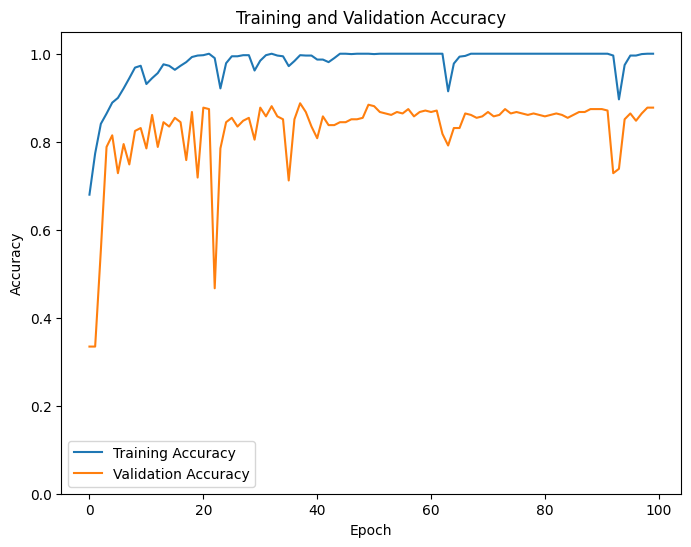

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.05])
plt.legend()
plt.show()

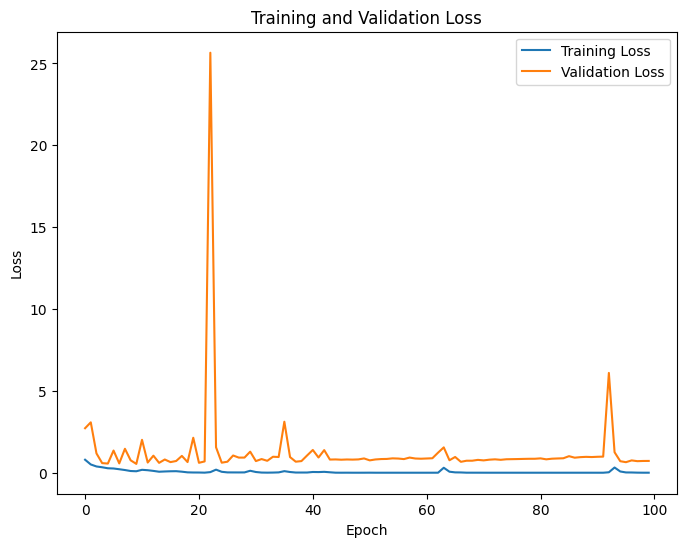

In [31]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model Explainablity

## Deeplift

### Setup Deeplift

In [32]:
def deeplift(model, img, baseline=None, pred_index=None):
    if baseline is None:
        baseline = np.zeros_like(img)
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)
    
    # difference between input and baseline
    diff = img - baseline
    
    # gradients of the predicted class VS respect to the input
    with tf.GradientTape() as tape:
        tape.watch(img)
        preds = model(img)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        score = preds[:, pred_index]
    
    grads = tape.gradient(score, img)
    
    # DeepLIFT multipliers: approximate as gradients
    multipliers = grads
    
    # contribution scores: (input - baseline) * multipliers
    contributions = diff * multipliers
    
    # Sum across channels + absolute
    heatmap = tf.reduce_sum(tf.abs(contributions), axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-10)  # Normalize
    return heatmap, pred_index

In [33]:
def display_heatmap(img, heatmap, alpha=0.5):
    if img.ndim == 4:
        img = img[0]
    if heatmap.ndim == 3:
        heatmap = heatmap[0]
    
    img = np.uint8(255 * (img - img.min()) / (img.max() - img.min() + 1e-10))
    
    heatmap = np.uint8(255 * heatmap)
    heatmap = tf.image.resize(heatmap[..., np.newaxis], (img.shape[0], img.shape[1])).numpy()[..., 0]
    heatmap = np.uint8(plt.cm.jet(heatmap)[..., :3] * 255)
    
    superimposed_img = heatmap * alpha + img * (1 - alpha)
    return np.uint8(superimposed_img)

### Select 3 samples per class

In [34]:
# Select 3 samples per class
num_classes = test_labels.shape[1]
samples_per_class = 3
class_indices = np.argmax(test_labels, axis=1)

selected_images = []
selected_labels = []

for class_idx in range(num_classes):
    # Find indices of samples belonging to this class
    class_samples = np.where(class_indices == class_idx)[0]
    if len(class_samples) < samples_per_class:
        print(f"Warning: Class {class_idx} has only {len(class_samples)} samples, using all available.")
        selected_samples = class_samples
    else:
        selected_samples = np.random.choice(class_samples, size=samples_per_class, replace=False)
    
    selected_images.extend(test_images[selected_samples])
    selected_labels.extend(test_labels[selected_samples])

### Visualize

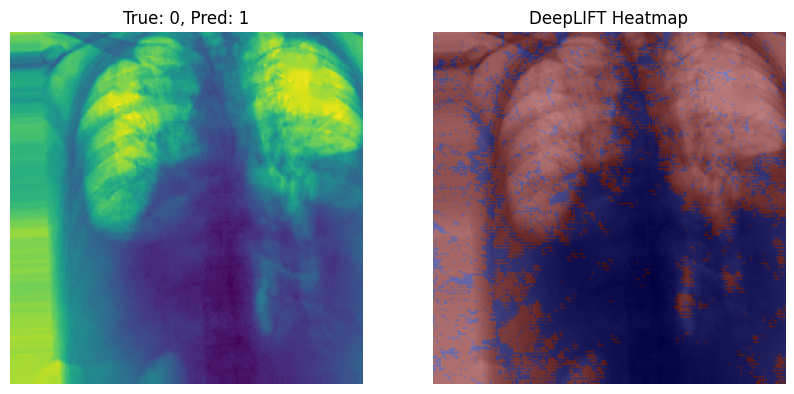

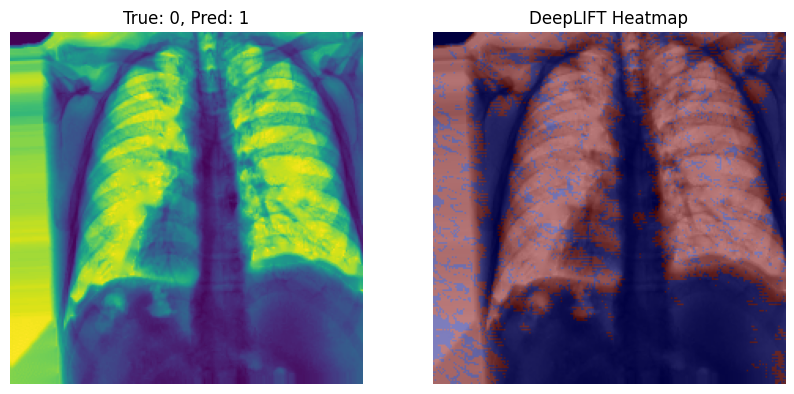

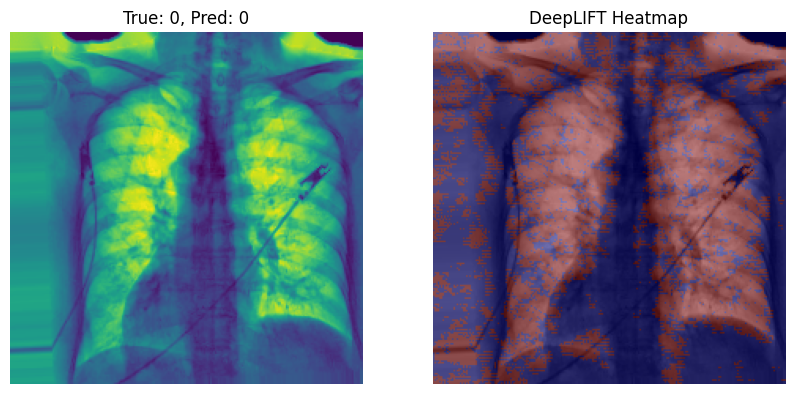

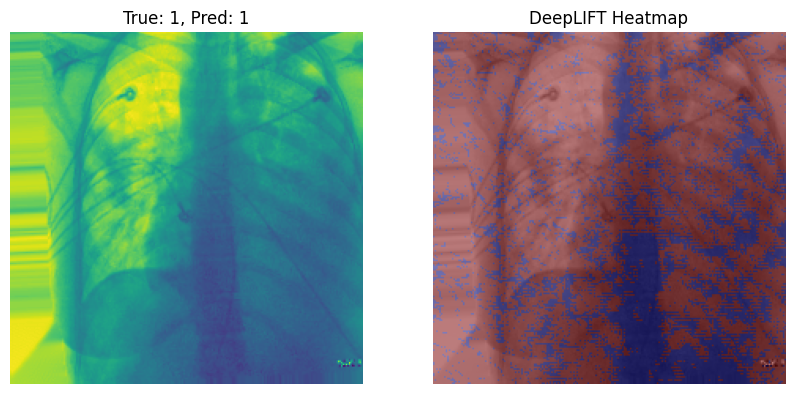

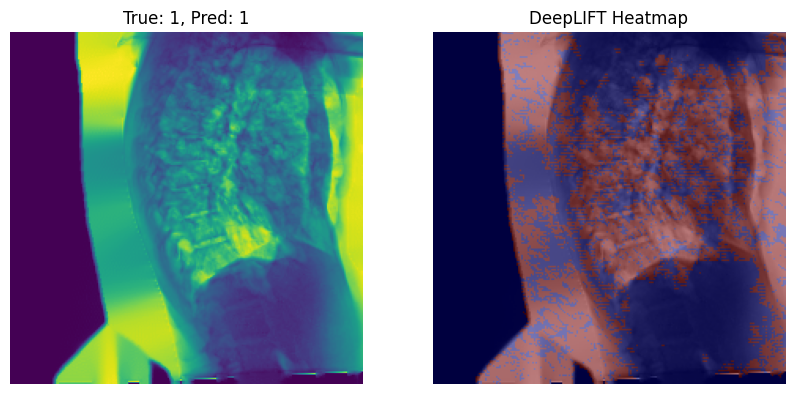

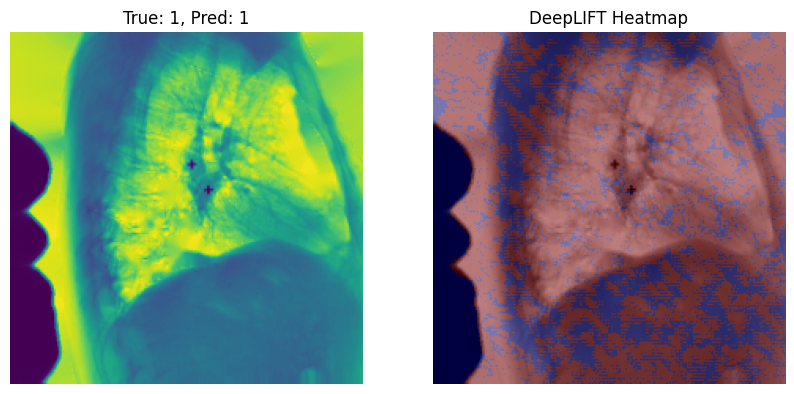

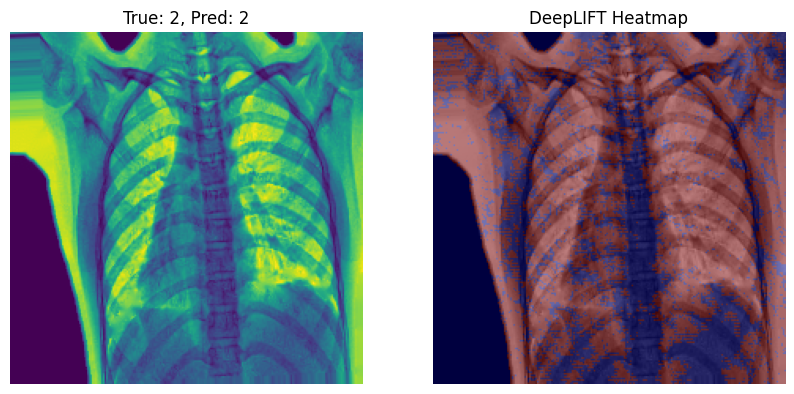

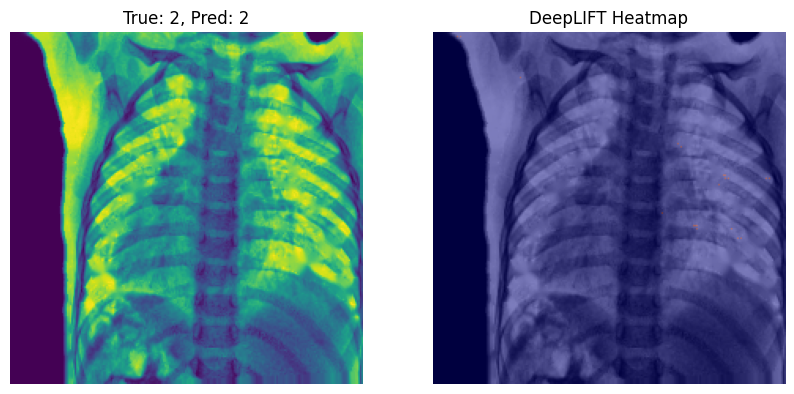

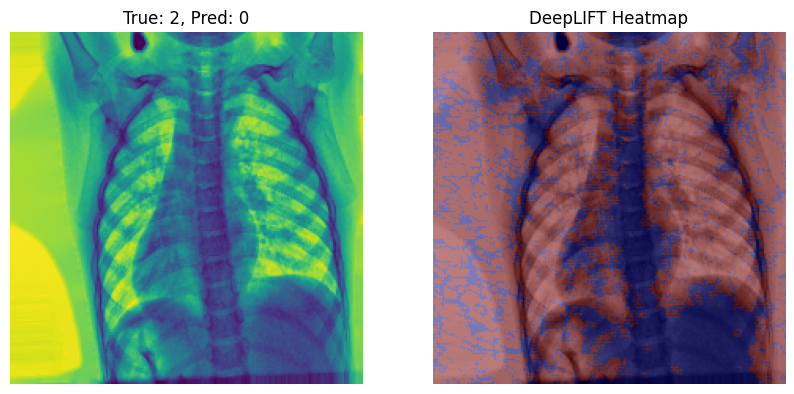

In [35]:
sample_images = np.array(selected_images)
sample_labels = np.array(selected_labels)

for i in range(len(sample_images)):
    img = sample_images[i:i+1]
    true_label = np.argmax(sample_labels[i])
    
    heatmap, pred_class = deeplift(model, img)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img[0])
    plt.title(f"True: {true_label}, Pred: {pred_class}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    superimposed_img = display_heatmap(img, heatmap)
    plt.imshow(superimposed_img)
    plt.title("DeepLIFT Heatmap")
    plt.axis('off')
    
    plt.show()

## Lime

In [36]:
def preprocess_for_lime(image):
    if len(image.shape) == 3:
        image = np.squeeze(image, axis=-1)
    img_rgb = np.stack([image] * 3, axis=-1)
    img_viz = image
    return img_rgb, img_viz

In [37]:
class_names = ['COVID-19', 'Pneumonia', 'Normal']
def predict_fn(images):
    images = images[:, :, :, 0:1]
    preds = model.predict(images, verbose=0)
    return preds

In [38]:
def explain_with_lime(train_images, train_labels, raw_images=None, class_names=class_names):
    explainer = lime_image.LimeImageExplainer()
    segmenter = quickshift

    if raw_images is None:
        raw_images = train_images

    if len(train_labels.shape) == 2:
        train_labels = np.argmax(train_labels, axis=1)
    
    selected_images = {}
    for class_idx, class_name in enumerate(class_names):
        # Find the first image for this class
        mask = (train_labels == class_idx)
        if np.any(mask):
            selected_images[class_name] = train_images[mask][0]
        else:
            raise ValueError(f"No images found for class {class_name}")

    for class_name in class_names:
        img = selected_images[class_name]
        img_viz_raw = raw_images[np.argmax(train_labels == class_names.index(class_name))] if raw_images is not None else img
        
        img_rgb, img_viz = preprocess_for_lime(img)
        
        explanation = explainer.explain_instance(
            img_rgb,
            predict_fn,
            top_labels=3,
            num_samples=500,
            segmentation_fn=segmenter
        )
        
        img_for_model = img_rgb[:, :, 0:1]
        img_for_model = np.expand_dims(img_for_model, axis=0)
        pred = model.predict(img_for_model, verbose=0)
        predicted_class = class_names[np.argmax(pred)]

        _, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=True,
            num_features=5,
            hide_rest=False
        )

        img_rgb_viz = np.stack([img_viz] * 3, axis=-1)
        highlighted_image = mark_boundaries(img_rgb_viz, mask, color=(1, 0, 0))

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        
        ax1.imshow(img_viz, cmap='gray')
        ax1.set_title(f'Original ({class_name})\nPredicted: {predicted_class}')
        ax1.axis('off')
        
        ax2.imshow(highlighted_image)
        ax2.set_title('LIME Explanation')
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"Class: {class_name}")
        print(f"Predicted probabilities: {dict(zip(class_names, pred[0]))}\n")

  0%|          | 0/500 [00:00<?, ?it/s]

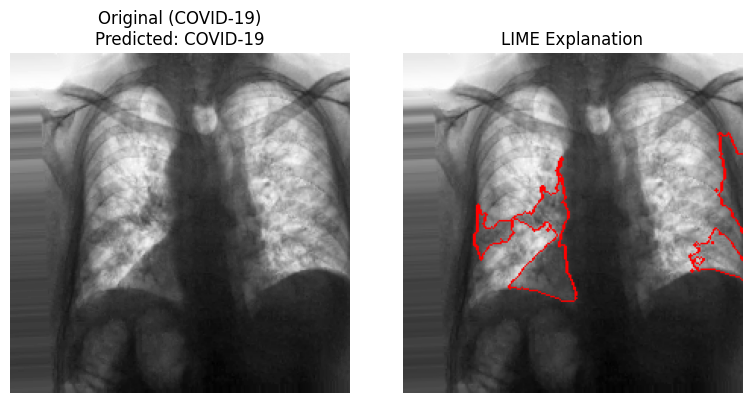

Class: COVID-19
Predicted probabilities: {'COVID-19': 0.99905354, 'Pneumonia': 0.0008078574, 'Normal': 0.00013861398}



  0%|          | 0/500 [00:00<?, ?it/s]

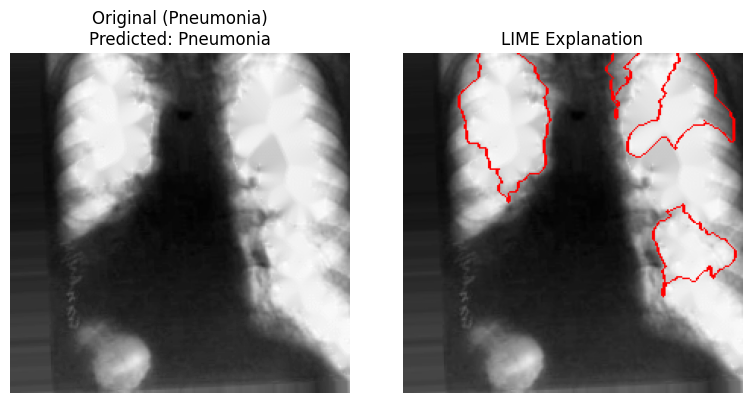

Class: Pneumonia
Predicted probabilities: {'COVID-19': 0.00012164016, 'Pneumonia': 0.9998779, 'Normal': 3.5177254e-07}



  0%|          | 0/500 [00:00<?, ?it/s]

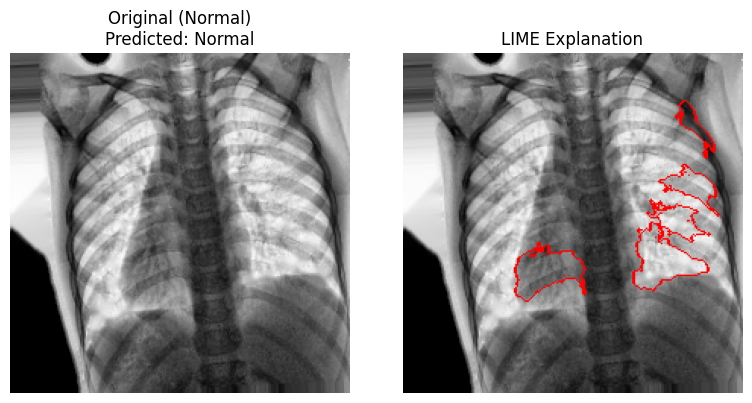

Class: Normal
Predicted probabilities: {'COVID-19': 2.5749475e-08, 'Pneumonia': 2.724824e-10, 'Normal': 1.0}



In [39]:
explain_with_lime(train_images, train_labels, raw_images=train_images, class_names=class_names)

## Grad-Cam

In [42]:
def gradCam(image, true_label, layer_conv_name, model):
    model_grad = tf.keras.models.Model(inputs=model.input, 
                                       outputs=[model.get_layer(layer_conv_name).output, 
                                                model.output])
    pred = []
    with tf.GradientTape() as tape:
        conv_output, predictions = model_grad(image)

        pred.append(np.argmax(predictions))
        
        tape.watch(conv_output)
        loss = tf.keras.losses.categorical_crossentropy(true_label, predictions)
    
    grad = tape.gradient(loss, conv_output)
    grad = tf.reduce_mean(tf.abs(grad), axis=(0, 1, 2))
    
    conv_output = np.squeeze(conv_output.numpy())
    
    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= grad[i]
        
    heatmap = tf.reduce_mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / tf.reduce_max(heatmap + 1e-8)  
    heatmap = cv2.resize(heatmap.numpy(), (224, 224))
    pred = np.array(pred)
    return np.squeeze(heatmap), np.squeeze(image), pred

In [44]:
def getHeatMap(images, labels, model):
    heatmaps = []
    predictions = []
    for index in range(128):
        heatmap, image, pred = gradCam(images[index:index+1], 
                                 labels[index:index+1], 
                                 'conv2d_25', model) 
        heatmaps.append(heatmap)
        predictions.append(pred)
    return np.array(heatmaps), predictions


heatmaps, pred = getHeatMap(test_images, test_labels, model)
print(heatmaps.shape)  

(128, 224, 224)


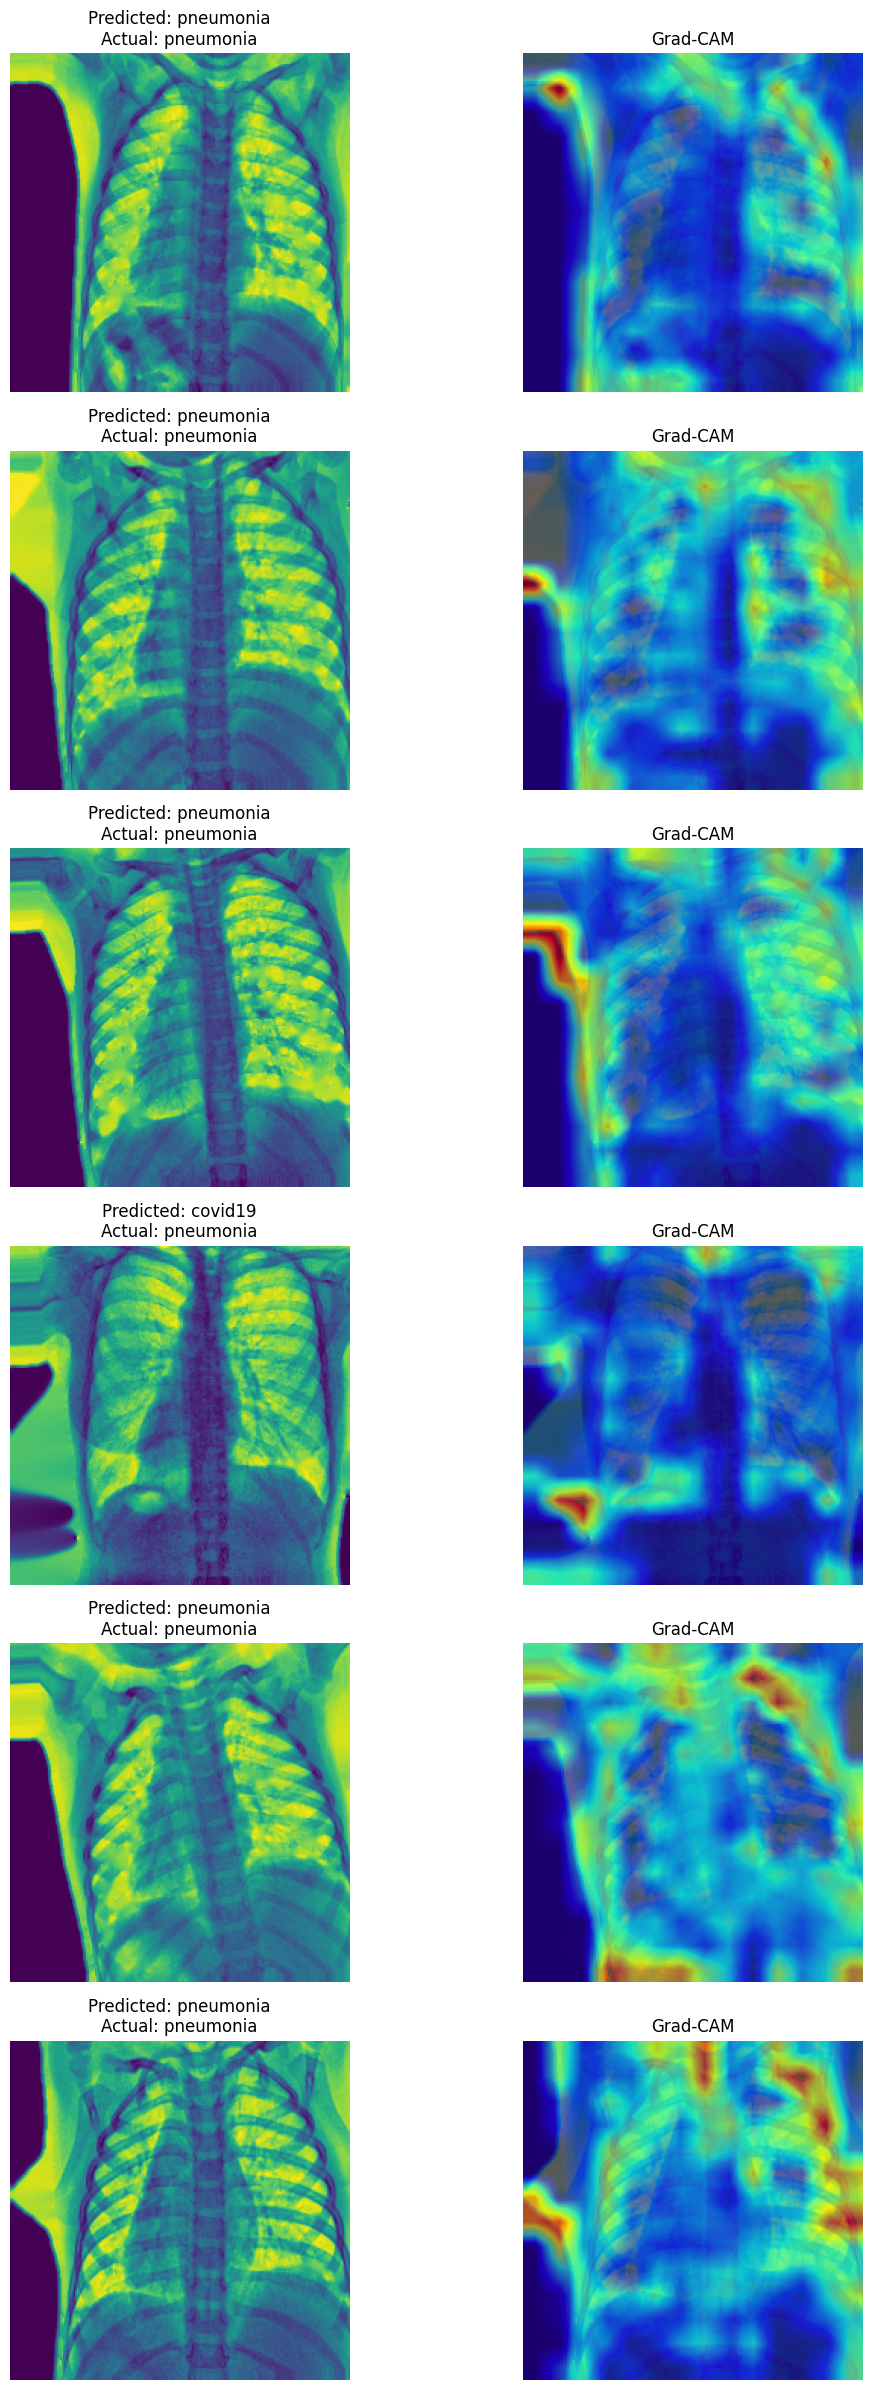

In [45]:
class_dict_c = {0:'covid19', 1:'normal', 2:'pneumonia'}
def draw(images, gradcam_heatmaps, labels, pred,  num_images=6):
    plt.figure(figsize=(12, 4 * num_images))
    for i in range(num_images):
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(images[i])
        title_pred = class_dict_c[pred[i][0]]
        title_actual = class_dict_c[np.argmax(labels[i])]
        plt.title(f'Predicted: {title_pred}\nActual: {title_actual}')

  
        
        plt.axis('off')

        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(images[i])
        plt.imshow(gradcam_heatmaps[i], alpha=0.6, cmap='jet')
        plt.title('Grad-CAM')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

draw(test_images[:6], heatmaps[:6], test_labels[:6], pred)

# Features Importance

In [52]:
class_names = ['COVID-19', 'Pneumonia', 'Normal']

class_indices = {}
for i in range(len(test_labels)):
    true_label = np.argmax(test_labels[i])
    if true_label not in class_indices:
        class_indices[true_label] = i
    if len(class_indices) == len(class_names):
        break

missing_classes = [cls for cls in range(len(class_names)) if cls not in class_indices]
if missing_classes:
    missing_class_names = [class_names[cls] for cls in missing_classes]
    raise ValueError(f"No images found for classes: {missing_class_names}")

In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def permutation_importance(image, model, class_index, model_name, raw_image, patch_size=32):
    if len(image.shape) == 2:
        image = np.expand_dims(image, axis=-1)
    image = np.expand_dims(image, axis=0)

    correct_prob = model.predict(image, verbose=0)[0, class_index]

    h, w = image.shape[1], image.shape[2]
    importance_map = np.zeros((h // patch_size, w // patch_size))
    n_channels = image.shape[3]

    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            permuted = image.copy()
            for c in range(n_channels):
                permuted[0, i:i+patch_size, j:j+patch_size, c] = np.random.rand(patch_size, patch_size)

            pred_prob = model.predict(permuted, verbose=0)[0, class_index]
            importance = correct_prob - pred_prob
            importance_map[i // patch_size, j // patch_size] = importance

    importance_map = (importance_map - importance_map.min()) / (importance_map.max() - importance_map.min() + 1e-8)

    heatmap = cv2.resize(importance_map, (w, h))

    plt.figure(figsize=(6, 6))
    if len(raw_image.shape) == 2 or (len(raw_image.shape) == 3 and raw_image.shape[-1] == 1):
        plt.imshow(raw_image, cmap='gray')
    else:
        plt.imshow(raw_image)
    plt.imshow(heatmap, cmap='hot', alpha=0.5)
    plt.title(f"{model_name}")
    plt.axis('off')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

In [61]:
images = {
    'COVID-19': test_images[class_indices[0]],
    'Pneumonia': test_images[class_indices[1]],
    'Normal': test_images[class_indices[2]]
}

raw_images = {
    'COVID-19': test_images[class_indices[0]],
    'Pneumonia': test_images[class_indices[1]],
    'Normal': test_images[class_indices[2]]
}

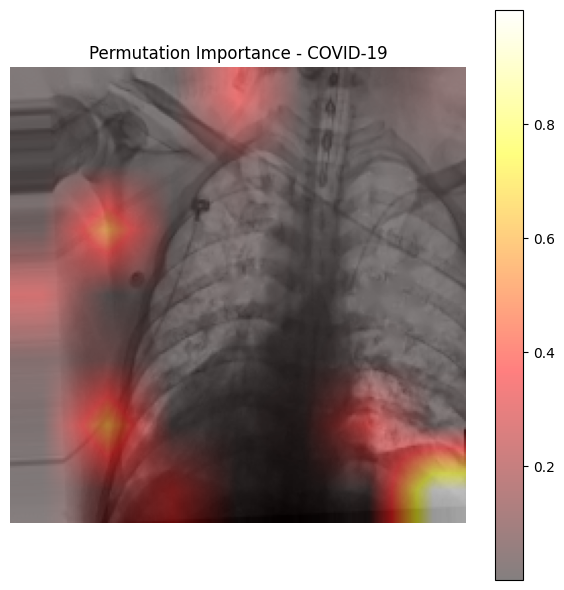

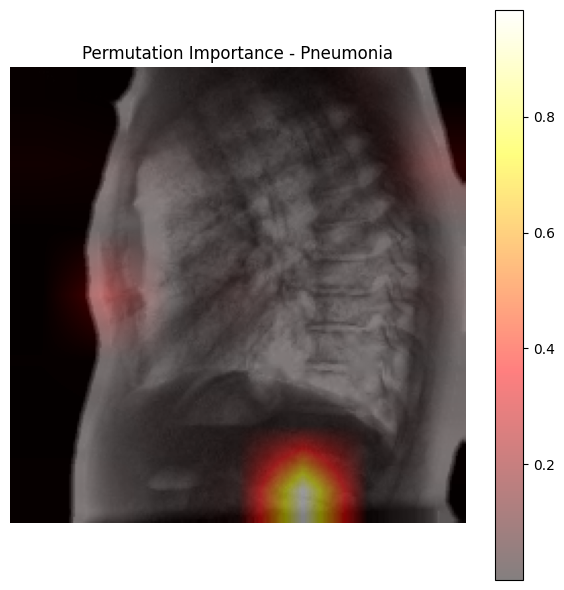

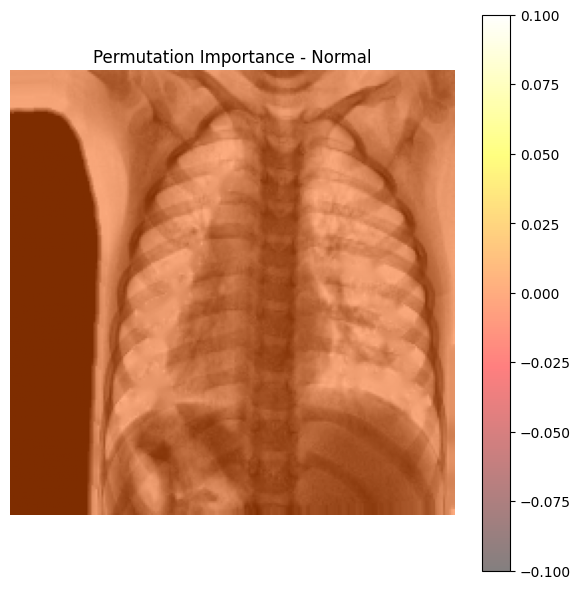

In [62]:
for class_name, processed_image in images.items():
    class_index = class_names.index(class_name)
    image_for_display = raw_images[class_name]
    
    if len(image_for_display.shape) == 3 and image_for_display.shape[-1] == 1:
        image_for_display = np.squeeze(image_for_display, axis=-1)
    elif len(image_for_display.shape) == 3 and image_for_display.shape[-1] == 3:
        pass  # Keep RGB as is
    else:
        raise ValueError(f"Unsupported raw_image shape for {class_name}: {image_for_display.shape}")

    model_name = f"Permutation Importance - {class_name}"
    permutation_importance(
        image=processed_image,
        model=model,
        class_index=class_index,
        model_name=model_name,
        raw_image=image_for_display
    )